# Defines

## Libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle

# show all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

sklearn.set_config(transform_output="pandas")

In [2]:
def plot_roc_curve(y_true, y_score):
    # Compute the false positive rate (fpr) and true positive rate (tpr)
    fpr, tpr, _ = roc_curve(y_true, y_score)

    # Compute the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


## Data

In [3]:
# specify the directory you want to use
df = pd.read_csv("data/compas-scores-two-years.csv")

## Rows and Columns

In [4]:
df["is_male"] = np.where(df.sex == "Male", 1, 0)
df["is_black"] = np.where(df.race == "African-American", 1, 0)
df["is_felony"] = np.where(df.c_charge_degree == "F", 1, 0)
df["compas_is_recid"] = np.where(df.score_text == "High", 1, 0)

In [5]:
# reproduce the samples used in ProPublica analysis
df_filtered = df[(df['days_b_screening_arrest'] <= 30) &
        (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) &
        (df['c_charge_degree'] != 'O') &
        (df['v_score_text'] != 'N/A')]

print(len(df_filtered))

6172


In [6]:
# Categorical columns
cat_cols = [
    # "race",
]

# Numerical columns
num_cols = [
    "is_male",
    "age",
    "juv_fel_count",
    "juv_misd_count",
    "juv_other_count",
    "priors_count",
    "days_b_screening_arrest",
    "is_felony",
    "is_black",
]

# Label columns
labels = [
    "v_decile_score",
    "decile_score",
    "is_recid",
    "two_year_recid",
    "compas_is_recid"
]

feature_cols = cat_cols + num_cols

X_filtered = df_filtered[feature_cols]
Y_filtered = df_filtered[labels]
Y_filtered

,v_decile_score,decile_score,is_recid,two_year_recid,compas_is_recid
0,1,1,0,0,0
1,1,3,1,1,0
2,3,4,1,1,0
5,1,1,0,0,0
6,2,6,1,1,0
...,...,...,...,...,...
7209,5,7,0,0,0
7210,5,3,0,0,0
7211,1,1,0,0,0
7212,2,2,0,0,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, Y_filtered, test_size=0.2, random_state=42)

y_train_compas = y_train["compas_is_recid"]
y_test_compas = y_test["compas_is_recid"]
y_train_true = y_train["two_year_recid"]
y_test_true = y_test["two_year_recid"]

# Print the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4937, 9)
X_test shape: (1235, 9)
y_train shape: (4937, 5)
y_test shape: (1235, 5)


## Check performance of orignal compas model

In [8]:
# check performance of compas model
print(
    classification_report(
        y_true=Y_filtered["two_year_recid"], y_pred=Y_filtered["compas_is_recid"]
    )
)

              precision    recall  f1-score   support

           0       0.61      0.91      0.73      3363
           1       0.74      0.30      0.43      2809

    accuracy                           0.63      6172
   macro avg       0.68      0.61      0.58      6172
weighted avg       0.67      0.63      0.59      6172



# Train model based on Compas

## Logistics Regression

### Train

In [9]:
model = LogisticRegression()
model.fit(X_train, y_train_compas)

LogisticRegression()

### Check performance

In [10]:
y_pred_compas_logis = model.predict(X_test)
y_pred_proba_compas_logis = model.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1011
           1       0.77      0.34      0.48       224

    accuracy                           0.86      1235
   macro avg       0.82      0.66      0.70      1235
weighted avg       0.85      0.86      0.84      1235



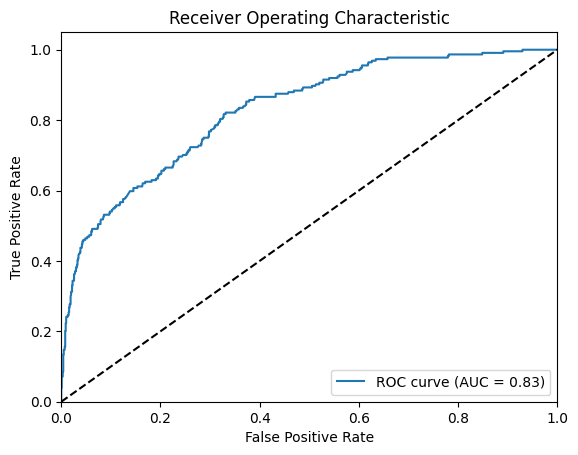

In [11]:
print(
    classification_report(
        y_true=y_test_compas, y_pred=y_pred_compas_logis
    )
)
plot_roc_curve(y_test_compas, y_pred_proba_compas_logis)

              precision    recall  f1-score   support

           0       0.59      0.98      0.73       683
           1       0.83      0.15      0.25       552

    accuracy                           0.61      1235
   macro avg       0.71      0.56      0.49      1235
weighted avg       0.70      0.61      0.52      1235



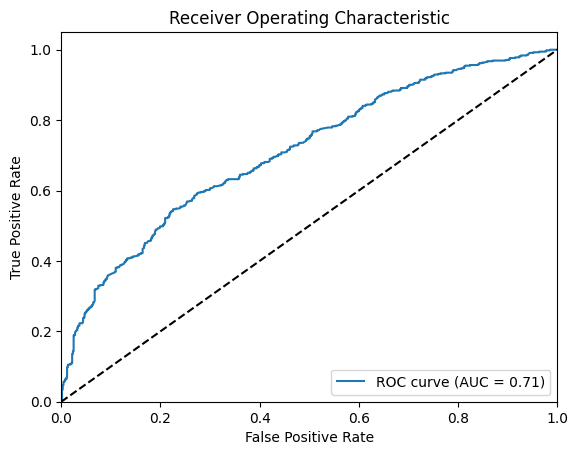

In [12]:
print(
    classification_report(
        y_true=y_test_true, y_pred=y_pred_compas_logis
    )
)
plot_roc_curve(y_test_true, y_pred_proba_compas_logis)

## XGBoost

### Train

In [13]:


# train again using xgboost
# Set the parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1
}

# Train the XGBoost model
model_xgb = xgb.XGBClassifier(**params)
model_xgb.fit(X_train, y_train_compas)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### Check performance

In [14]:
# Make predictions
y_pred_compas_xgb = model_xgb.predict(X_test)
y_pred_proba_compas_xgb = model_xgb.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1011
           1       0.75      0.37      0.50       224

    accuracy                           0.86      1235
   macro avg       0.81      0.67      0.71      1235
weighted avg       0.85      0.86      0.84      1235



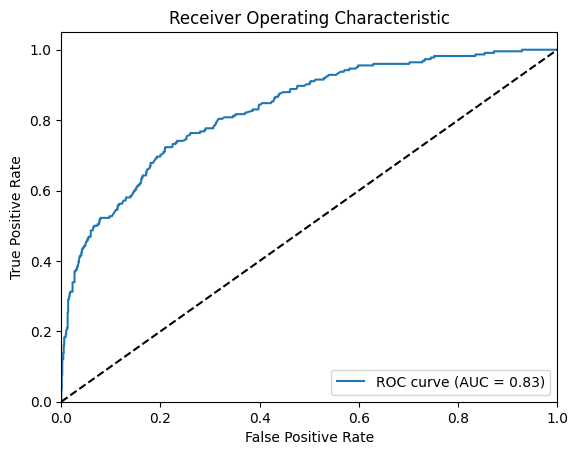

In [15]:
# Print the classification report
print(
    classification_report(
        y_true=y_test_compas, y_pred=y_pred_compas_xgb
    )
)
plot_roc_curve(y_test_compas, y_pred_proba_compas_xgb)

              precision    recall  f1-score   support

           0       0.59      0.97      0.74       683
           1       0.84      0.17      0.28       552

    accuracy                           0.61      1235
   macro avg       0.71      0.57      0.51      1235
weighted avg       0.70      0.61      0.53      1235



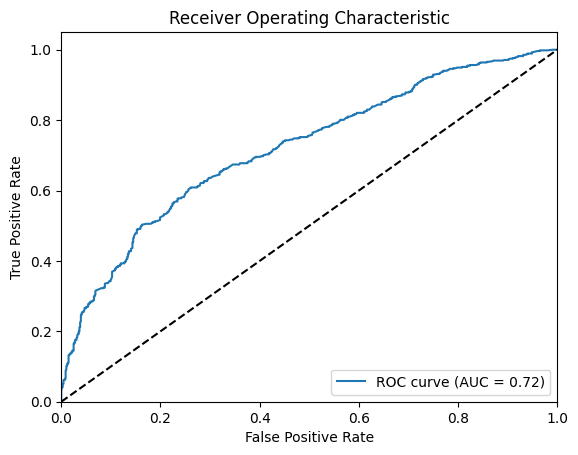

In [16]:
# Print the classification report
print(
    classification_report(
        y_true=y_test_true, y_pred=y_pred_compas_xgb
    )
)
plot_roc_curve(y_test_true, y_pred_proba_compas_xgb)

# Train model based on true

## Logistics Regression

### Train

In [17]:
model_logis = LogisticRegression()
model_logis.fit(X_train, y_train_true)

LogisticRegression()

### Check performance

In [18]:
y_pred_true_logis = model_logis.predict(X_test)
y_pred_proba_true_logis = model_logis.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1011
           1       0.38      0.75      0.50       224

    accuracy                           0.73      1235
   macro avg       0.65      0.74      0.66      1235
weighted avg       0.83      0.73      0.76      1235



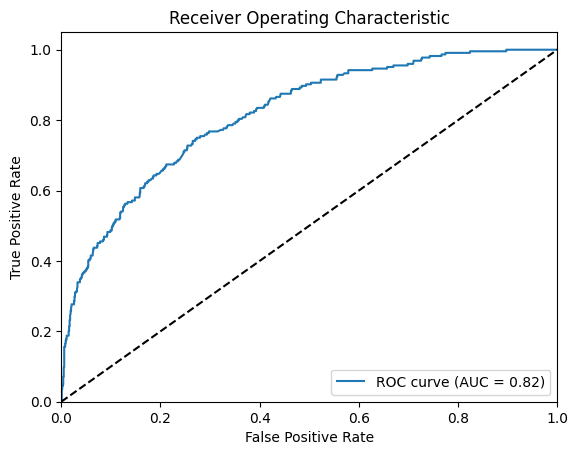

In [19]:
print(
    classification_report(
        y_true=y_test_compas, y_pred=y_pred_true_logis
    )
)
plot_roc_curve(y_test_compas, y_pred_proba_true_logis)

              precision    recall  f1-score   support

           0       0.67      0.78      0.72       683
           1       0.66      0.53      0.59       552

    accuracy                           0.67      1235
   macro avg       0.67      0.65      0.65      1235
weighted avg       0.67      0.67      0.66      1235



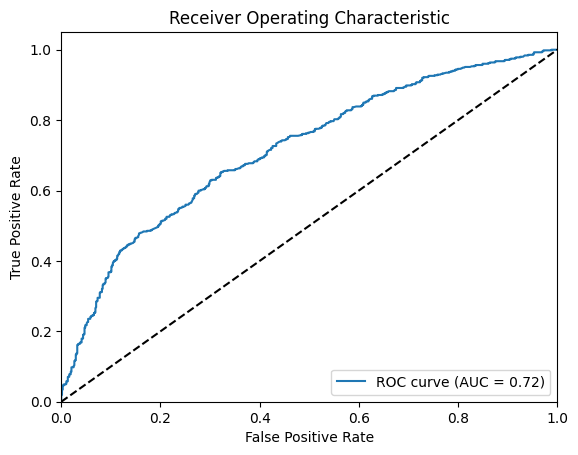

In [20]:
print(
    classification_report(
        y_true=y_test_true, y_pred=y_pred_true_logis
    )
)
plot_roc_curve(y_test_true, y_pred_proba_true_logis)

## XGBoost

### Train

In [21]:
# train again using xgboost
# Set the parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1
}

# Train the XGBoost model
model_xgb = xgb.XGBClassifier(**params)
model_xgb.fit(X_train, y_train_true)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### Check performance

In [22]:
y_pred_true_xgb = model_xgb.predict(X_test)
y_pred_proba_true_xgb = model_xgb.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.93      0.68      0.79      1011
           1       0.35      0.78      0.48       224

    accuracy                           0.70      1235
   macro avg       0.64      0.73      0.64      1235
weighted avg       0.83      0.70      0.73      1235



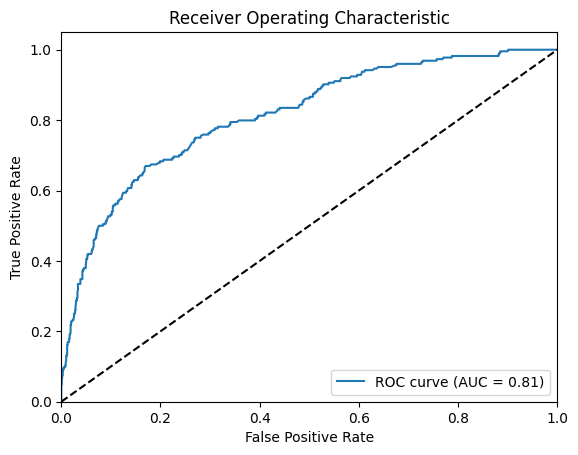

In [23]:
# Print the classification report
print(
    classification_report(
        y_true=y_test_compas, y_pred=y_pred_true_xgb
    )
)
plot_roc_curve(y_test_compas, y_pred_proba_true_xgb)

              precision    recall  f1-score   support

           0       0.70      0.75      0.72       683
           1       0.66      0.60      0.63       552

    accuracy                           0.68      1235
   macro avg       0.68      0.68      0.68      1235
weighted avg       0.68      0.68      0.68      1235



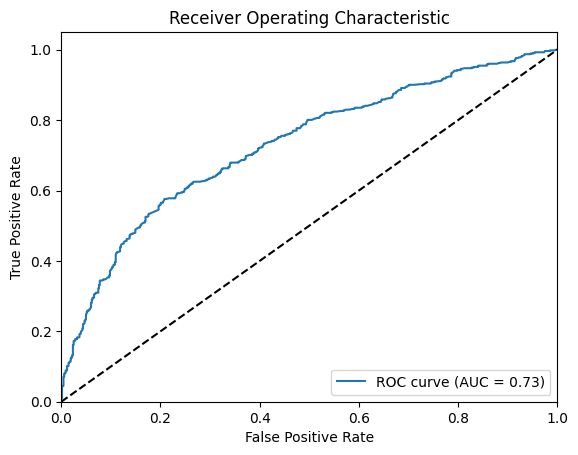

In [24]:
# Print the classification report
print(
    classification_report(
        y_true=y_test_true, y_pred=y_pred_true_xgb
    )
)
plot_roc_curve(y_test_true, y_pred_proba_true_xgb)

# Hyperparameter tuning

In [25]:
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [26]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 1.0, 0.1),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train_true)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test_true, y_pred)
    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [28]:
best_params = study.best_params
best_score = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Best Hyperparameters: {'max_depth': 3, 'learning_rate': 0.017714332323792124, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0.18594374970884212, 'min_child_weight': 1, 'n_estimators': 500}
Best Score: 0.6890688259109312


In [29]:
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train_true)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.18594374970884212, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.017714332323792124,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Check performance

In [30]:
y_pred_final_xgb = final_model.predict(X_test)
y_pred_proba_final_xgb = final_model.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.93      0.68      0.79      1011
           1       0.35      0.78      0.48       224

    accuracy                           0.70      1235
   macro avg       0.64      0.73      0.64      1235
weighted avg       0.83      0.70      0.73      1235



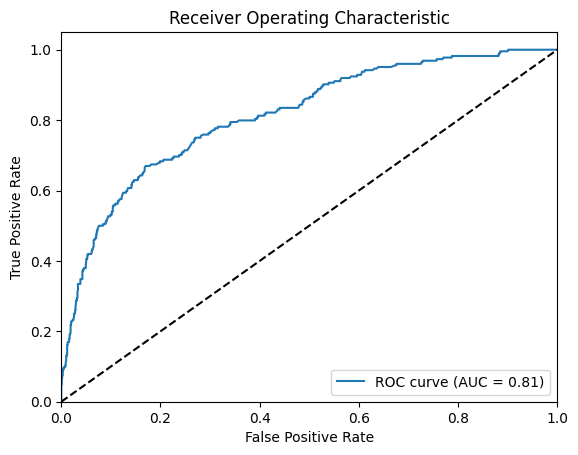

In [31]:
# Print the classification report
print(
    classification_report(
        y_true=y_test_compas, y_pred=y_pred_final_xgb
    )
)
plot_roc_curve(y_test_compas, y_pred_proba_true_xgb)

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       683
           1       0.67      0.60      0.63       552

    accuracy                           0.69      1235
   macro avg       0.69      0.68      0.68      1235
weighted avg       0.69      0.69      0.69      1235



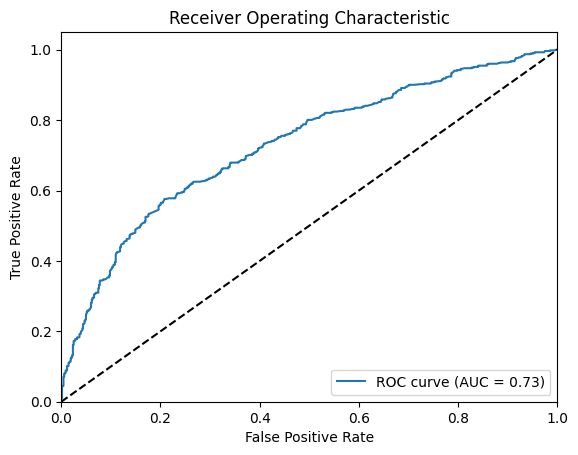

In [32]:
# Print the classification report
print(
    classification_report(
        y_true=y_test_true, y_pred=y_pred_final_xgb
    )
)
plot_roc_curve(y_test_true, y_pred_proba_true_xgb)

Brief score losses: (the smaller the better)
Base model: 0.2070
Isotonic regression: 0.2084
Logistics regression: 0.2076

Log loss: (the smaller the better)
Base model: 0.6024
Isotonic regression: 0.6884
Logistics regression: 0.6041


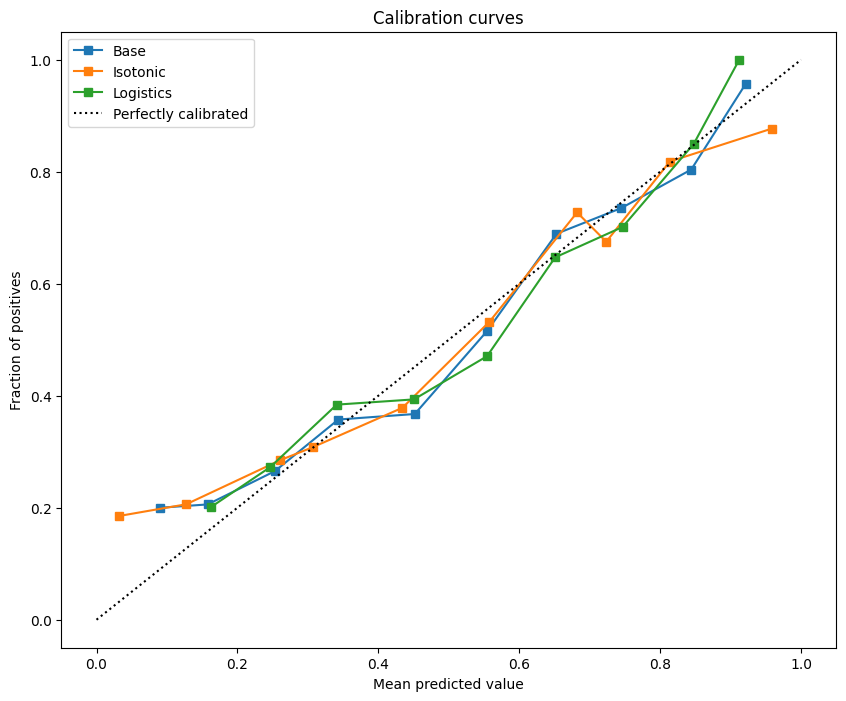

In [33]:
# import sklean CalibratedClassifierCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, log_loss

y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Isotonic Regression
iso_clf = CalibratedClassifierCV(final_model, method="isotonic", cv="prefit")
iso_clf.fit(X_train, y_train_true)
iso_y_pred_proba = iso_clf.predict_proba(X_test)[:, 1]

# Logistics Regression (signmoid)
sig_clf = CalibratedClassifierCV(final_model, method="sigmoid", cv="prefit")
sig_clf.fit(X_train, y_train_true)
sig_y_pred_proba = sig_clf.predict_proba(X_test)[:, 1]

print("Brief score losses: (the smaller the better)")
base_score = brier_score_loss(y_test_true, y_pred_proba)
iso_score = brier_score_loss(y_test_true, iso_y_pred_proba)
sig_score = brier_score_loss(y_test_true, sig_y_pred_proba)
print(f"Base model: {base_score:.4f}")
print(f"Isotonic regression: {iso_score:.4f}")
print(f"Logistics regression: {sig_score:.4f}")

print("\nLog loss: (the smaller the better)")
based_log_loss = log_loss(y_test_true, y_pred_proba)
iso_log_loss = log_loss(y_test_true, iso_y_pred_proba)
sig_log_loss = log_loss(y_test_true, sig_y_pred_proba)
print(f"Base model: {based_log_loss:.4f}")
print(f"Isotonic regression: {iso_log_loss:.4f}")
print(f"Logistics regression: {sig_log_loss:.4f}")

plt.figure(figsize=(10, 8))
for probs, name in [(y_pred_proba, "Base"), (iso_y_pred_proba, "Isotonic"), (sig_y_pred_proba, "Logistics")]:
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_true, probs, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=name)


plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.legend()
plt.title("Calibration curves")
plt.show()

# Save model and save data

In [34]:
# Save data
data = {
    'X_train': X_train,
    'y_train_true': y_train_true,
    'y_train_compas': y_train_compas,
    'X_test': X_test,
    'y_test_true': y_test_true,
    'y_test_compas': y_test_compas
}

with open('output/data.pkl', 'wb') as f:
    pickle.dump(data, f)

# Save model
with open('output/model.pkl', 'wb') as f:
    pickle.dump(final_model, f)